In [64]:
import numpy as np
import numpy.ma as ma

from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import ndimage
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.nddata import bitmask
from astropy.nddata.bitmask import BitFlagNameMap
import math

import copy

from scipy.ndimage import gaussian_filter1d

In [65]:
import os
current_directory = os.getcwd()
print(current_directory)

/global/u1/j/jlargett/DESI_SGA/Morphology


In [3]:
SGA_color_data = Table.read('SGA_Color_withGini.fits')

In [4]:
# Path to a random image in NERSC
f1 = math.trunc(SGA_color_data['RA'][1])
f2 = math.trunc((1000*SGA_color_data['RA'][1]))
f3 = math.trunc((100000*SGA_color_data['RA'][1]))
f4 = 'm' if SGA_color_data['DEC'][1] < 0 else 'p'
f5 = abs(math.trunc((100000*SGA_color_data['DEC'][1])))
path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
fits_file = fits.open(path)
image = fits_file[0].data
bit_mask = fits_file[1].data

In [5]:
image.shape

(3, 227, 227)

In [6]:
bit_mask.shape

(227, 227)

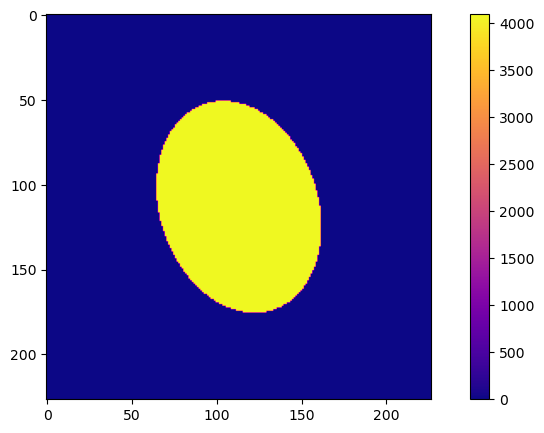

In [7]:
# Showing image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(bit_mask, cmap='plasma')
plt.colorbar()

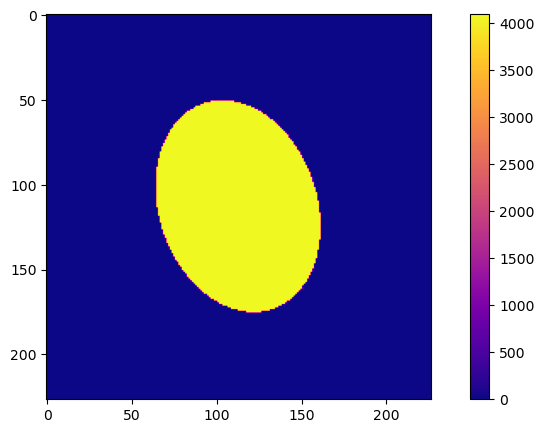

In [8]:
# Flipped mask 
plt.rcParams["figure.figsize"] = (10, 5)
flipped_bitmask = ndimage.rotate(bit_mask, 180)
plt.imshow(flipped_bitmask, cmap='plasma')
plt.colorbar()

In [9]:
# Reshape the data
if image.shape[0] == 3:
    image_data = np.transpose(image, (1, 2, 0))
image_data.shape

(227, 227, 3)

In [10]:
fits_file.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


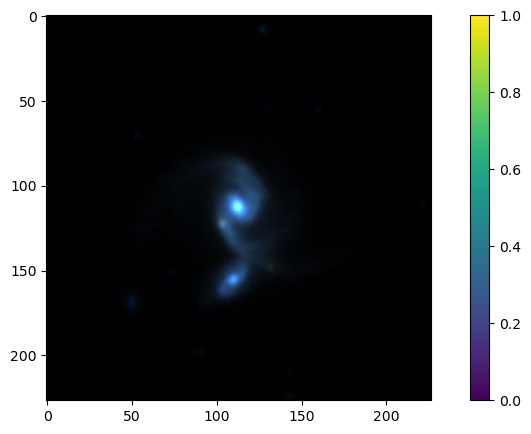

In [11]:
# Showing normal image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(image_data)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


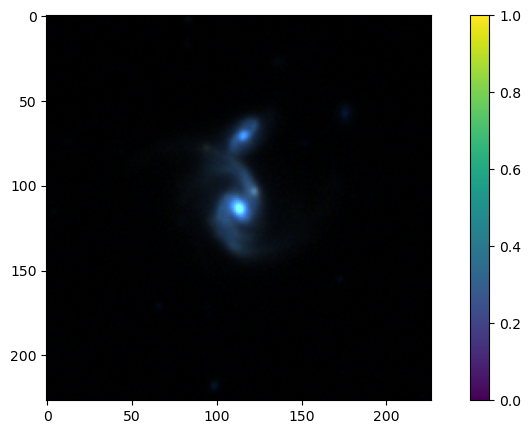

In [12]:
# Showing flipped image by 180 degrees
plt.rcParams["figure.figsize"] = (10, 5)
mg_180 = ndimage.rotate(image_data, 180, reshape=True)
plt.imshow(mg_180)
plt.colorbar()

## Create the mask for normal image

In [13]:
# Bits in the dict
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # SGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
    SATUR_I    = 0x4000,
    ALLMASK_I  = 0x8000,
    SUB_BLOB   = 0x10000,
)

In [14]:
# Generate bitmask to apply to image
condition = bit_mask & MASKBITS['GALAXY'] != 0
# mask_ = np.where(ellipse_fit == condition, 0, 1)
mask_ = condition.astype(int)

In [15]:
# Generate bitmask to apply to image
condition2 = mask_ & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
# mask_2 = np.where(mask_ == condition2, 1, 0)
mask_2 = mask_ & ~condition2

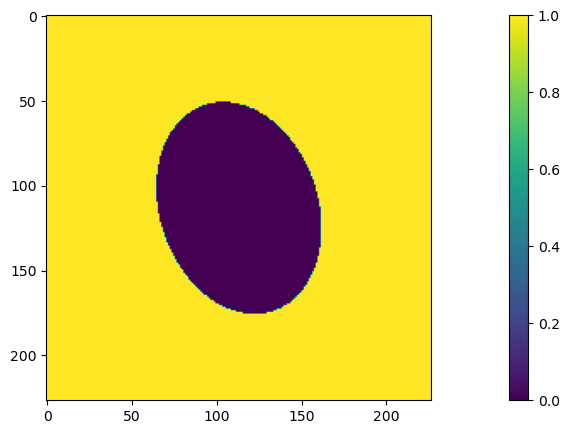

In [16]:
# Showing masked image
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(~(mask_2.astype(bool)))
plt.colorbar();

## Make the mask (318, 318, 3), where the third dimension represents the same 2D mask array duplicated three times

In [17]:
mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
mask.shape

(227, 227, 3)

In [18]:
mimage_data = ma.array(image_data, mask=~mask)
mimage_data.shape

(227, 227, 3)

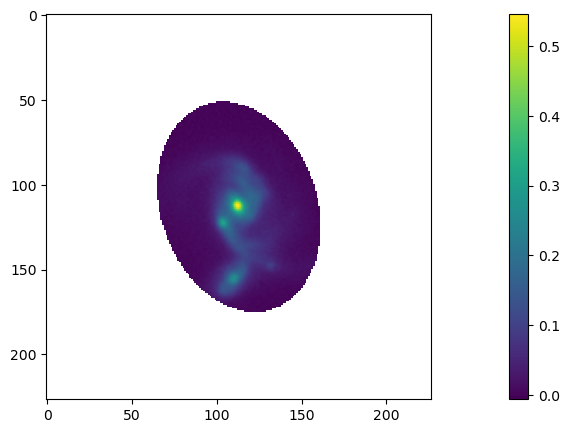

In [19]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(mimage_data[:,:,0])
plt.colorbar();

## Repeat process for flipped image

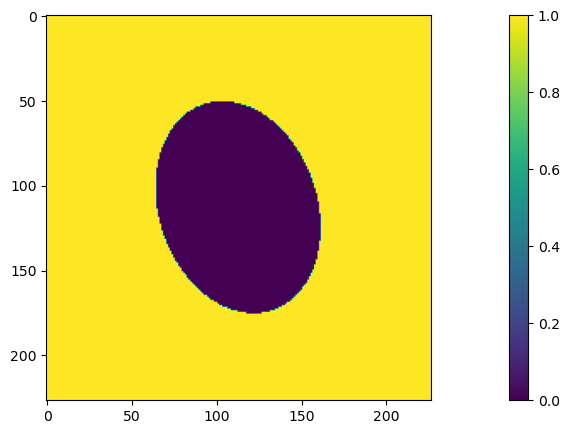

In [20]:
condition = flipped_bitmask & MASKBITS['GALAXY'] != 0
flipped_mask = condition.astype(int)
condition2 = flipped_mask & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
# mask_2 = np.where(mask_ == condition2, 1, 0)
flipped_mask_2 = flipped_mask & ~condition2
# Showing masked image
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(~(flipped_mask_2.astype(bool)))
plt.colorbar();

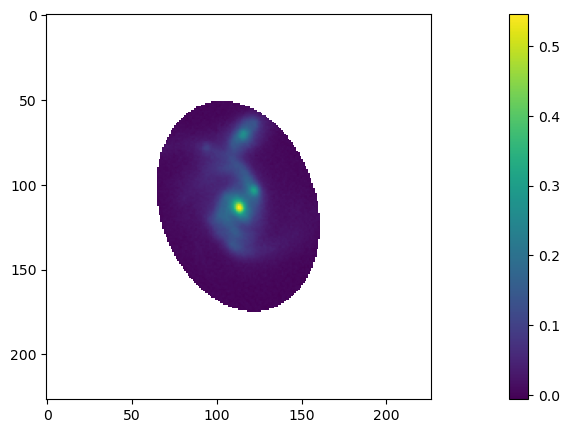

In [21]:
mask_180 = np.dstack([flipped_mask_2.astype(bool), flipped_mask_2.astype(bool), flipped_mask_2.astype(bool)])
flipped_mimage_data = ma.array(mg_180, mask=~mask_180)
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(flipped_mimage_data[:,:,0])
plt.colorbar();

## Mask each color separately for both normal and flipped images 

In [22]:
# normal image
mg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
mr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
mz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

In [23]:
# flipped image
mg_image_180 = ma.array(mg_180[:,:,0], mask=~flipped_mask_2.astype(bool))
mr_image_180 = ma.array(mg_180[:,:,1], mask=~flipped_mask_2.astype(bool))
mz_image_180 = ma.array(mg_180[:,:,2], mask=~flipped_mask_2.astype(bool))

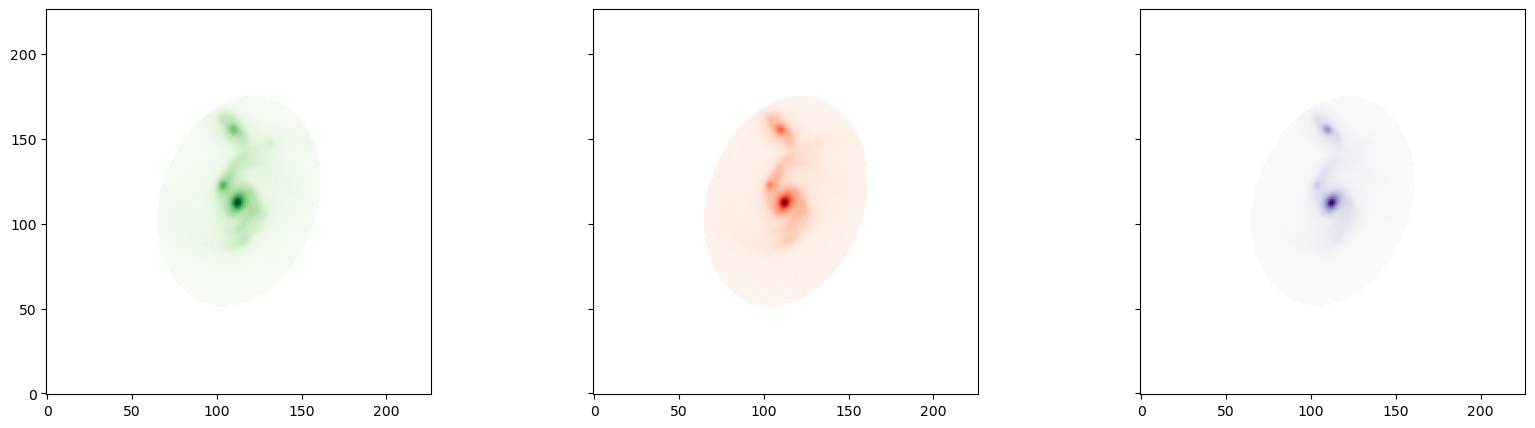

In [24]:
plt.figure()
ax1=plt.subplot(131)
plt.imshow(mg_image, origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mr_image, origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mz_image, origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

### Asymmetry Showcase of image

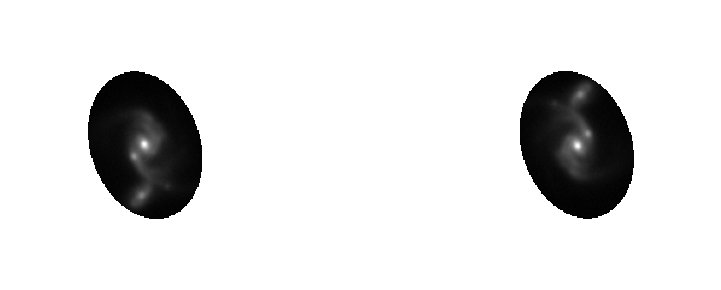

In [25]:
# Show normal and rotated images
fig = plt.figure(figsize=(10, 3))
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(mimage_data[:,:,0], cmap='gray')
ax1.set_axis_off()
ax2.imshow(flipped_mimage_data[:,:,0], cmap='gray')
ax2.set_axis_off()
fig.set_layout_engine('tight')
plt.show()

# Asymmetry formula
## A = $\frac{ \Sigma|I(i, j) - I_{180} (i, j)|}{\Sigma|I(i, j)|}$
### where $I(i, j)$ is the galaxy's image and $I_{180}(i, j)$ is the image rotated by 180 degrees about the galaxy's center.

In [26]:
print("mg_180[:,:,0] shape:", mg_180[:,:,0].shape)
print("flipped_mask_2 shape:", flipped_mask_2.shape)

mg_180[:,:,0] shape: (227, 227)
flipped_mask_2 shape: (227, 227)


In [27]:
# Calculate pixel-wise absolute intensity difference for each band
abs_diff_g = np.abs(mg_image - mg_image_180)
abs_diff_r = np.abs(mr_image - mr_image_180)
abs_diff_z = np.abs(mz_image - mz_image_180)

# Sum absolute intensity differences over the entire image for each band
sum_abs_diff_g = np.sum(abs_diff_g)
sum_abs_diff_r = np.sum(abs_diff_r)
sum_abs_diff_z = np.sum(abs_diff_z)

# Sum pixel values over the entire image for each band
sum_original_g = np.sum(mg_image)
sum_original_r = np.sum(mr_image)
sum_original_z = np.sum(mz_image)

# Calculate the asymmetry parameter for each band
asymmetry_parameter_g = sum_abs_diff_g / sum_original_g
asymmetry_parameter_r = sum_abs_diff_r / sum_original_r
asymmetry_parameter_z = sum_abs_diff_z / sum_original_z

print("Asymmetry Parameter (G band):", asymmetry_parameter_g)
print("Asymmetry Parameter (R band):", asymmetry_parameter_r)
print("Asymmetry Parameter (Z band):", asymmetry_parameter_z)

Asymmetry Parameter (G band): 0.5649225
Asymmetry Parameter (R band): 0.5858903
Asymmetry Parameter (Z band): 0.60765356


In [61]:
from scipy.ndimage import zoom

# Create a list to store indices of processed galaxies
processed_galaxies = []

# Create a deep copy of the original catalog
SGA_color_data_copy = copy.deepcopy(SGA_color_data)

n_galaxies = len(SGA_color_data)


SGA_color_data_copy['Asymmetry_G'] = np.NaN * np.ones(n_galaxies)
SGA_color_data_copy['Asymmetry_R'] = np.NaN * np.ones(n_galaxies)
SGA_color_data_copy['Asymmetry_Z'] = np.NaN * np.ones(n_galaxies)


for i in range(0, 400):
    f1 = math.trunc(SGA_color_data['RA'][i])
    f2 = math.trunc((1000*SGA_color_data['RA'][i]))
    f3 = math.trunc((100000*SGA_color_data['RA'][i]))
    f4 = 'm' if SGA_color_data['DEC'][i] < 0 else 'p'
    f5 = abs(math.trunc((100000*SGA_color_data['DEC'][i])))
    path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
    
    fits_file = fits.open(path)
    
    #checking to see if mask exists
    if len(fits_file) < 2:
        continue
        
    image = fits_file[0].data
    bit_mask = fits_file[1].data #length of fits file, fits file header
    
    print("image shape:", image.shape, "bitmask shape:", bit_mask.shape)
    
    flipped_bitmask = ndimage.rotate(bit_mask, 180)
    
    print("Processing galaxy", i)
        
    # checking if the file exists
    if not os.path.exists(path):
        # Skip processing for this galaxy
        print(f"Skipping galaxy {i} - File not found: {path}")
        continue
    
    print("Processing...", i)    
    image = fits_file[0].data
    bit_mask = fits_file[1].data
    
    print("image shape:", image.shape, "bitmask shape:", bit_mask.shape)
    
    flipped_bitmask = ndimage.rotate(bit_mask, 180)
    
    # reshape the data
    # checking to see if the galaxy has 3 color channels
    if image.shape[0] == 3:
        # the tuple swaps the 1st and 3rd dimensions, resulting in a new array, and assigns this array to the variable image_data
        image_data = np.transpose(image, (1, 2, 0))
        #print("image_data shape:", image_data.shape)
        fits_file.close()
    
        # rotate image_data by 180 degrees, assign to mg_180. The reshaping option ensures that the output array retains the shape containing all the valid rotated data.
        mg_180 = ndimage.rotate(image_data, 180, reshape=True)
    
        # generate bitmask to apply to image
        condition = bit_mask & MASKBITS['GALAXY'] != 0
        mask_int = condition.astype(int)
        #print("mask_int:", mask_int)
        
        # filtering out specific pixels in an image based on these additional conditions.
        condition2 = mask_int & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
        mask_2 = mask_int & ~condition2
        
        # make the mask (318, 318, 3), where the third dimension represents the same 2D mask array duplicated three times
        mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
        mimage_data = ma.array(image_data, mask=~mask)
        #print("mask shape:", mask.shape)
        #print("mimage_data shape:", mimage_data.shape)
        
        # generate flipped bitmask
        conditionf = flipped_bitmask & MASKBITS['GALAXY'] != 0
        flipped_mask = conditionf.astype(int)
        condition2f = flipped_mask & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
        flipped_mask_2 = flipped_mask & ~condition2f
        
        # make the mask (318, 318, 3), where the third dimension represents the same 2D mask array duplicated three times
        mask_180 = np.dstack([flipped_mask_2.astype(bool), flipped_mask_2.astype(bool), flipped_mask_2.astype(bool)])
        flipped_mimage_data = ma.array(mg_180, mask=~mask_180)
        #print("maks_180 shape:", mask_180.shape, "flipped_mimage_data shape", flipped_mimage_data.shape)
        
        # mask each color
        
        # normal images
        mg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
        mr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
        mz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))
        
        # flipped image
        mg_image_180 = ma.array(mg_180[:,:,0], mask=~flipped_mask_2.astype(bool))
        mr_image_180 = ma.array(mg_180[:,:,1], mask=~flipped_mask_2.astype(bool))
        mz_image_180 = ma.array(mg_180[:,:,2], mask=~flipped_mask_2.astype(bool))
        
        # calculate asym parameter
        
        # Calculate pixel-wise absolute intensity difference for each band
        abs_diff_g = np.abs(mg_image - mg_image_180)
        abs_diff_r = np.abs(mr_image - mr_image_180)
        abs_diff_z = np.abs(mz_image - mz_image_180)

        # Sum absolute intensity differences over the entire image for each band
        sum_abs_diff_g = np.sum(abs_diff_g)
        sum_abs_diff_r = np.sum(abs_diff_r)
        sum_abs_diff_z = np.sum(abs_diff_z)

        # Sum pixel values over the entire image for each band
        sum_original_g = np.sum(mg_image)
        sum_original_r = np.sum(mr_image)
        sum_original_z = np.sum(mz_image)

        # Calculate the asymmetry parameter for each band
        asym_param_g = sum_abs_diff_g / sum_original_g
        asym_param_r = sum_abs_diff_r / sum_original_r
        asym_param_z = sum_abs_diff_z / sum_original_z

        # Append asymmetry values to the new columns in the copied catalog
        SGA_color_data_copy[i]['Asymmetry_G'] = asym_param_g
        SGA_color_data_copy[i]['Asymmetry_R'] = asym_param_r
        SGA_color_data_copy[i]['Asymmetry_Z'] = asym_param_z
        
        # Append the index of the processed galaxy to the list
        processed_galaxies.append(i)
        
        #print("Galaxy processed!", i)

image shape: (3, 213, 213) bitmask shape: (213, 213)
Processing galaxy 0
Processing... 0
image shape: (3, 213, 213) bitmask shape: (213, 213)
image shape: (3, 227, 227) bitmask shape: (227, 227)
Processing galaxy 1
Processing... 1
image shape: (3, 227, 227) bitmask shape: (227, 227)
image shape: (3, 185, 185) bitmask shape: (185, 185)
Processing galaxy 2
Processing... 2
image shape: (3, 185, 185) bitmask shape: (185, 185)
image shape: (3, 303, 303) bitmask shape: (303, 303)
Processing galaxy 3
Processing... 3
image shape: (3, 303, 303) bitmask shape: (303, 303)
image shape: (3, 268, 268) bitmask shape: (268, 268)
Processing galaxy 4
Processing... 4
image shape: (3, 268, 268) bitmask shape: (268, 268)
image shape: (3, 221, 221) bitmask shape: (221, 221)
Processing galaxy 75
Processing... 75
image shape: (3, 221, 221) bitmask shape: (221, 221)
image shape: (3, 299, 299) bitmask shape: (299, 299)
Processing galaxy 76
Processing... 76
image shape: (3, 299, 299) bitmask shape: (299, 299)
im

/tmp/ipykernel_989697/3108299705.py:122: RuntimeWarning: invalid value encountered in float_scalars
  asym_param_r = sum_abs_diff_r / sum_original_r
/tmp/ipykernel_989697/3108299705.py:123: RuntimeWarning: invalid value encountered in float_scalars
  asym_param_z = sum_abs_diff_z / sum_original_z


image shape: (3, 298, 298) bitmask shape: (298, 298)
Processing galaxy 320
Processing... 320
image shape: (3, 298, 298) bitmask shape: (298, 298)
image shape: (3, 215, 215) bitmask shape: (215, 215)
Processing galaxy 321
Processing... 321
image shape: (3, 215, 215) bitmask shape: (215, 215)
image shape: (3, 261, 261) bitmask shape: (261, 261)
Processing galaxy 322
Processing... 322
image shape: (3, 261, 261) bitmask shape: (261, 261)
image shape: (3, 196, 196) bitmask shape: (196, 196)
Processing galaxy 323
Processing... 323
image shape: (3, 196, 196) bitmask shape: (196, 196)
image shape: (3, 261, 261) bitmask shape: (261, 261)
Processing galaxy 324
Processing... 324
image shape: (3, 261, 261) bitmask shape: (261, 261)
image shape: (3, 204, 204) bitmask shape: (204, 204)
Processing galaxy 325
Processing... 325
image shape: (3, 204, 204) bitmask shape: (204, 204)
image shape: (3, 289, 289) bitmask shape: (289, 289)
Processing galaxy 326
Processing... 326
image shape: (3, 289, 289) bitm

In [62]:
print(SGA_color_data)
print(SGA_color_data_copy)

 SGA_ID    SGA_GALAXY    ...       GINI_R             GINI_Z      
------- ---------------- ... ------------------ ------------------
      2       SGA-2020 2 ... 0.7681378368431697 0.7630303041651973
      3       SGA-2020 3 ... 0.6431633406632249 0.6479186696819089
      4       SGA-2020 4 ... 0.5822626869300935 0.5633981646534456
      7       SGA-2020 7 ... 0.7451875941565521 0.7507873649960575
     18      SGA-2020 18 ... 0.7483232923668451 0.7850335473806666
     20      SGA-2020 20 ...                 --                 --
     24      SGA-2020 24 ...                 --                 --
     25      SGA-2020 25 ...                 --                 --
     26      SGA-2020 26 ...                 --                 --
     29      SGA-2020 29 ...                 --                 --
    ...              ... ...                ...                ...
5005190 SGA-2020 5005190 ... 0.7889433464407202 0.7648069416262857
5005195 SGA-2020 5005195 ... 0.7973787683694045  0.78145896825

In [63]:
# print the list of processed galaxies after the loop
print("Galaxies that were successfully processed:", processed_galaxies)

# check and print rows where asym_param_g, asym_param_r, and asym_param_z are not NaN
non_nan_rows = SGA_color_data_copy[
    ~np.isnan(SGA_color_data_copy['Asymmetry_G']) &
    ~np.isnan(SGA_color_data_copy['Asymmetry_R']) &
    ~np.isnan(SGA_color_data_copy['Asymmetry_Z'])
]

print(non_nan_rows)

Galaxies that were successfully processed: [0, 1, 2, 3, 4, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 2